In [9]:
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# from nltk.corpus import stopwords
# STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
pd.set_option('max_colwidth', 100)
df = pd.read_csv('data/bbc-news.csv')
df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and dig...
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseein...
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy...
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier ...
4,entertainment,ocean s twelve raids box office ocean s twelve the crime caper sequel starring george clooney ...
5,politics,howard hits back at mongrel jibe michael howard has said a claim by peter hain that the tory lea...
6,politics,blair prepares to name poll date tony blair is likely to name 5 may as election day when parliam...
7,sport,henman hopes ended in dubai third seed tim henman slumped to a straight sets defeat in his rain-...
8,sport,wilkinson fit to face edinburgh england captain jonny wilkinson will make his long-awaited retur...
9,entertainment,last star wars not for children the sixth and final star wars movie may not be suitable for yo...


In [15]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOP_WORDS)


In [16]:
df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [18]:
df_clean.head(10)

,text
0,tv future hands viewers home theatre systems plasma highdefinition tvs digital video recorders m...
1,worldcom boss left books worldcom boss bernie ebbers accused overseeing £ fraud accounting decis...
2,tigers wary farrell gamble leicester rushed making bid andy farrell great britain rugby league c...
3,yeading face newcastle fa cup premiership newcastle united face trip ryman premier league leader...
4,ocean s raids box office ocean s crime caper sequel starring george clooney brad pitt julia robe...
5,howard hits mongrel jibe michael howard said claim peter hain tory leader acting like attack mon...
6,blair prepares poll date tony blair likely election day parliament returns easter break bbc s po...
7,henman hopes ended dubai seed tim henman slumped straight sets defeat raininterrupted dubai open...
8,wilkinson fit face edinburgh england captain jonny wilkinson longawaited return injury edinburgh...
9,star wars children sixth final star wars movie suitable young children filmmaker george lucas sa...


In [21]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

In [22]:
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [23]:
df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)

In [24]:

df_clean.head(10)

,text,text_lemmatize
0,tv future hands viewers home theatre systems plasma highdefinition tvs digital video recorders m...,tv future hand viewer home theatre system plasma highdefinition tvs digital video recorder move ...
1,worldcom boss left books worldcom boss bernie ebbers accused overseeing £ fraud accounting decis...,worldcom boss leave book worldcom boss bernie ebber accuse oversee £ fraud accounting decision w...
2,tigers wary farrell gamble leicester rushed making bid andy farrell great britain rugby league c...,tiger wary farrell gamble leicester rush make bid andy farrell great britain rugby league captai...
3,yeading face newcastle fa cup premiership newcastle united face trip ryman premier league leader...,yeading face newcastle fa cup premiership newcastle united face trip ryman premier league leader...
4,ocean s raids box office ocean s crime caper sequel starring george clooney brad pitt julia robe...,ocean s raids box office ocean s crime caper sequel star george clooney brad pitt julia roberts ...
5,howard hits mongrel jibe michael howard said claim peter hain tory leader acting like attack mon...,howard hit mongrel jibe michael howard say claim peter hain tory leader act like attack mongrel ...
6,blair prepares poll date tony blair likely election day parliament returns easter break bbc s po...,blair prepare poll date tony blair likely election day parliament return easter break bbc s poli...
7,henman hopes ended dubai seed tim henman slumped straight sets defeat raininterrupted dubai open...,henman hope end dubai seed tim henman slump straight set defeat raininterrupte dubai open quarte...
8,wilkinson fit face edinburgh england captain jonny wilkinson longawaited return injury edinburgh...,wilkinson fit face edinburgh england captain jonny wilkinson longawaite return injury edinburgh ...
9,star wars children sixth final star wars movie suitable young children filmmaker george lucas sa...,star war child sixth final star war movie suitable young child filmmaker george lucas say tell t...


In [25]:
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [26]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

25044

In [27]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['s', 'say', 'mr', 'year', 'people', 'new', 'good', 'win', 'game', '£']

In [30]:
# min_count: minimum number of occurrences of a word in the corpus to be included in the model.
# window: the maximum distance between the current and predicted word within a sentence.
# size: the dimensionality of the feature vectors
# workers: I know my system is having 4 cores, 
w2v_model = Word2Vec(min_count=200, window=5, workers=4, vector_size=100)

In [31]:
# this line of code to prepare the model vocabulary
w2v_model.build_vocab(sentences)

In [53]:
# train word vectors
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100)

(16710791, 44528200)

In [54]:
# As we do not plan to train the model any further, 
# we are calling init_sims(), which will make the model much more memory-efficient
w2v_model.init_sims(replace=True)

C:\Users\ABHISH~1.KUM\AppData\Local\Temp/ipykernel_27168/294696631.py:3: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [55]:
# Explore the model
w2v_model.wv.most_similar(positive=['economy'])

[('economic', 0.6614837050437927),
 ('growth', 0.49819427728652954),
 ('rise', 0.4430432617664337),
 ('spending', 0.4076630771160126),
 ('fall', 0.37755441665649414),
 ('rate', 0.3688802719116211),
 ('continue', 0.36874839663505554),
 ('figure', 0.36788541078567505),
 ('dollar', 0.36404305696487427),
 ('increase', 0.3563252091407776)]

In [56]:
w2v_model.wv.most_similar(positive=['president'])

[('leader', 0.34406447410583496),
 ('spending', 0.269142210483551),
 ('eu', 0.25941985845565796),
 ('dollar', 0.24560190737247467),
 ('mr', 0.23412933945655823),
 ('economy', 0.23146018385887146),
 ('today', 0.22819532454013824),
 ('commission', 0.22298890352249146),
 ('budget', 0.2210911512374878),
 ('foreign', 0.2089729607105255)]

In [58]:
# how similar are these two words to each other 
w2v_model.wv.similarity('company', 'business')

0.38448915

In [68]:
def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    words = list(model.wv.index_to_key)
    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

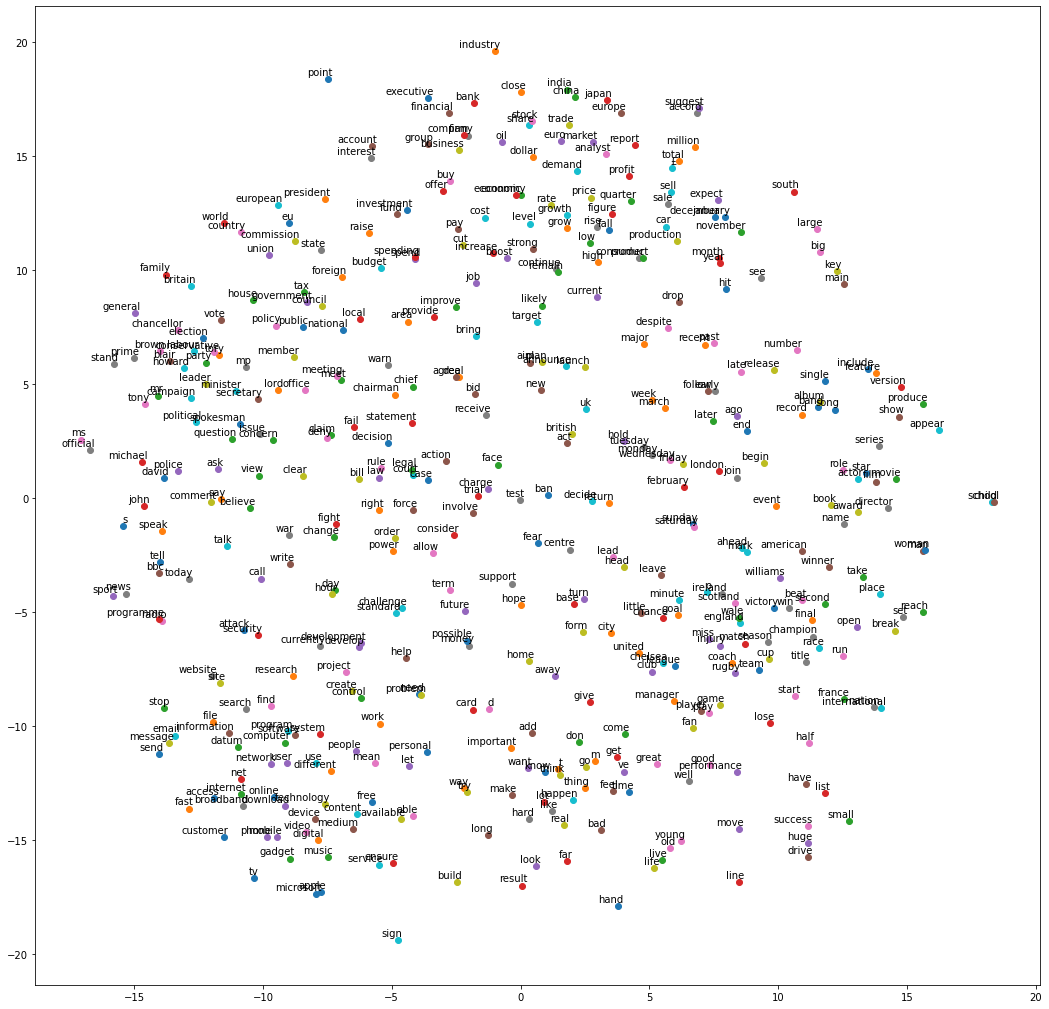

In [69]:
# Use t-SNE to represent high-dimensional data 
# and the underlying relationships between vectors in a lower-dimensional space.
tsne_plot(w2v_model)

In [71]:
# from gensim.models import KeyedVectors

# filename = 'GoogleNews-vectors-negative300.bin.gz'
# model = KeyedVectors.load_word2vec_format('data/bbc-news.csv', binary=True)
# # calculate: (king - man) + woman = ?
# result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
# print(result)

ValueError: invalid literal for int() with base 10: 'category,text'